In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution3D, MaxPooling3D, Conv3D
from keras.optimizers import SGD, RMSprop
from keras.utils import np_utils, generic_utils

import tensorflow as tf
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pyplot as pyplot

import numpy as np
import scipy.io
from PIL import Image
from sklearn.cross_validation import train_test_split
from sklearn import cross_validation
from sklearn import preprocessing

img_rows, img_cols, img_depth = 64, 64, 64

/home/xd/ws/tf/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/xd/ws/tf/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
root_dir = 'dataset_withlabel/'
listing = os.listdir(root_dir)
maxval = 0.46
classes = {'none':0, 'left':1, 'right':2, 'click':3, 'wrist':4}

In [3]:
frames = []
labels = []
nongesture_count = 0
for file in listing:
    file = root_dir + file
    data = scipy.io.loadmat(file)
    images = data['images']
    label = data['labels']
    num_frame = images.shape[0]

    for i in range(0, num_frame-64, 5):
        gt = label[i:i+64]
        if np.sum(gt) > 32:
            vol = images[i:i+64]
            vol = vol.reshape(64,64,64)
            frames.append(vol)
            labels.append(np.max(gt))
            
        if np.sum(gt) == 0 and nongesture_count < 2000:
            vol = images[i:i+64]
            vol = vol.reshape(64,64,64)
            frames.append(vol)
            labels.append(np.max(gt))
            nongesture_count = nongesture_count + 1

In [4]:
num_samples = len(frames)
frames[10].shape

(64, 64, 64)

In [6]:
X = np.zeros((num_samples, 1, img_rows, img_cols, img_depth))

In [7]:
for h in range(num_samples):
#     X[h][0][:][:][:] = frames_arr[h,:,:,:]
    X[h][0][:][:][:] = frames[h]

In [8]:
del frames

In [29]:
X = X.reshape(-1,64,64,64,1)
print(X.shape, 'train samples')

(8661, 64, 64, 64, 1) train samples


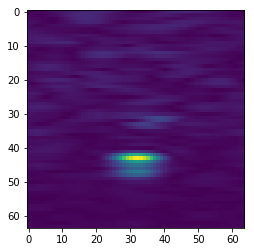

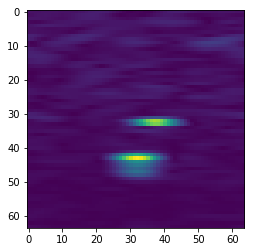

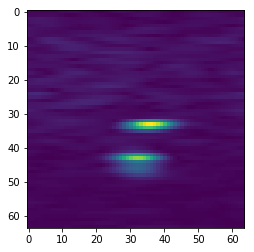

In [38]:
k = 200
vol = X[k]
for i in range(3):
    imgs = vol.reshape(64,64,64)
    img = imgs[:][:][i]
    plt.imshow(img)
    plt.show()

In [37]:
y = np_utils.to_categorical(labels, nb_classes)

X = X.astype('float32')
X -= np.mean(X)
X /= np.max(X)

In [40]:
np.save('X', X)

In [39]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
np.save('X_train', X_train)
np.save('X_val', X_val)
np.save('y_train', y_train)
np.save('y_val', y_val)

MemoryError: 

In [36]:
batch_size = 4
nb_classes = 5
nb_epoch = 100
patch_size = 64

nb_filters = [32, 32]
nb_pool = [3, 3]
nb_conv = [5, 5]

In [7]:
from keras import backend as K
K.clear_session()
model = Sequential()
print(nb_filters[0], 'filters')
print('input shape', img_rows, 'rows', img_cols, 'cols', patch_size, 'patchsize')

model.add(Conv3D(8,
                 (3, # depth
                  3, # rows
                  3), # cols
                 input_shape=(patch_size, img_rows, img_cols, 1),
                 activation='relu',
                 padding='SAME',
))
model.add(MaxPooling3D(pool_size=(nb_pool[0], nb_pool[0], nb_pool[0])))
model.add(Dropout(0.5))
model.add(Conv3D(8,
                 (3, # depth
                  3, # rows
                  3), # cols
                 activation='relu',
                 kernel_initializer='he_normal',
                 padding='SAME',
))
model.add(MaxPooling3D(pool_size=(nb_pool[0], nb_pool[0], nb_pool[0])))
model.add(Dropout(0.5))
model.add(Conv3D(16,
                 (3, # depth
                  3, # rows
                  3), # cols
                 activation='relu',
                 kernel_initializer='he_normal',
                 padding='SAME',
))
model.add(MaxPooling3D(pool_size=(nb_pool[0], nb_pool[0], nb_pool[0])))
model.add(Dropout(0.5))

model.add(Flatten())
# model.add(Dense(64, kernel_initializer='he_normal', activation='relu'))
model.add(Dense(nb_classes, kernel_initializer='he_normal'))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['mse', 'accuracy'])

32 filters
input shape 64 rows 64 cols 64 patchsize


In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 64, 64, 64, 8)     224       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 21, 21, 21, 8)     0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 21, 21, 21, 8)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 21, 21, 21, 8)     1736      
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 7, 7, 7, 8)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 7, 8)        0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 7, 7, 7, 16)       3472      
__________

In [65]:
hist = model.fit(
X_train,
y_train,
validation_data=(X_val, y_val),
batch_size=batch_size,
epochs=nb_epoch,
shuffle=True
)

MemoryError: 

In [57]:
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['acc']
val_acc = hist.history['val_acc']

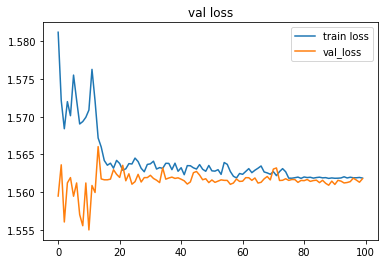

In [58]:
plt.plot(train_loss); plt.title('train loss')
plt.plot(val_loss); plt.title('val loss')
plt.legend(['train loss', 'val_loss'])

(0, 1)

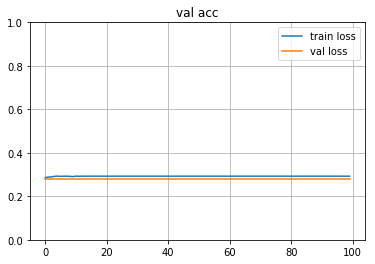

In [59]:
plt.plot(train_acc); plt.title('train acc')
plt.plot(val_acc); plt.title('val acc')
plt.legend(['train loss', 'val loss'])
plt.grid(True)
plt.ylim(0,1)

In [60]:
X.shape

(8661, 64, 64, 64, 1)

In [61]:
from keras import backend as K
K.clear_session()

In [66]:
np.save('X.npy', X)

In [67]:
np.save('y.npy', y)